In [22]:
import math
import random
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn.dense import Linear
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool

In [23]:
""" Create dataste of Pytorch Geometric Data objects """

nnodes = 100
nnfeature = 1
nefeatures = 1
dataset = []

for _ in range(2000):
    # undirected graph contains edges in both direcitons
    source_nodes, target_nodes = [], []
    edge_weights = []
    for i in range(1, nnodes+1):
        source_nodes += [(i-1) % nnodes, i % nnodes]
        target_nodes += [i % nnodes, (i-1) % nnodes]
        weight = random.randrange(50)
        edge_weights += [[weight], [weight]]

    x = torch.tensor([[random.choice([-1, 1])] for _ in range(nnodes)], dtype=torch.float)
    edge_index = torch.LongTensor([source_nodes, target_nodes])
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    # calculate resulting energy of the lattice
    energy = 0
    for i in range(1, nnodes):
        energy += x[i-1][0] * x[i][0] * edge_attr[i][0]
        # energy += edge_attr[i][0]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=energy)
    dataset.append(data)

# check if edges are encoded correctly
for data in dataset:
    assert data.edge_index.max() < data.num_nodes

In [24]:
""" Splitting and batching the dataset """
from torch_geometric.loader import DataLoader

split = (len(dataset) // 10) * 2
train_dataset = dataset[split:]
test_dataset = dataset[:split]

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=1)
print(f"Number of training graphs: {len(train_loader)}")
print(f"Number of testing graphs: {len(test_loader)}")

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)

Number of training graphs: 1600
Number of testing graphs: 400
Step 1:
Number of graphs in the current batch: 1
DataBatch(x=[100, 1], edge_index=[2, 200], edge_attr=[200, 1], y=[1], batch=[100], ptr=[2])
Step 2:
Number of graphs in the current batch: 1
DataBatch(x=[100, 1], edge_index=[2, 200], edge_attr=[200, 1], y=[1], batch=[100], ptr=[2])
Step 3:
Number of graphs in the current batch: 1
DataBatch(x=[100, 1], edge_index=[2, 200], edge_attr=[200, 1], y=[1], batch=[100], ptr=[2])
Step 4:
Number of graphs in the current batch: 1
DataBatch(x=[100, 1], edge_index=[2, 200], edge_attr=[200, 1], y=[1], batch=[100], ptr=[2])
Step 5:
Number of graphs in the current batch: 1
DataBatch(x=[100, 1], edge_index=[2, 200], edge_attr=[200, 1], y=[1], batch=[100], ptr=[2])
Step 6:
Number of graphs in the current batch: 1
DataBatch(x=[100, 1], edge_index=[2, 200], edge_attr=[200, 1], y=[1], batch=[100], ptr=[2])
Step 7:
Number of graphs in the current batch: 1
DataBatch(x=[100, 1], edge_index=[2, 200], 

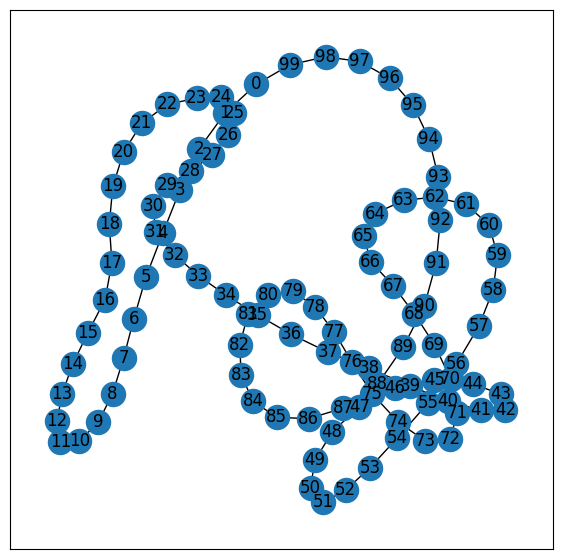

In [25]:
def visualize_graph(G):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True, cmap="Set2")
    plt.show()

graph = dataset[0]
G = to_networkx(graph, to_undirected=True)
visualize_graph(G)


In [26]:

class GraphNetRegression(torch.nn.Module):
    def __init__(self, num_node_features, num_output_features):
        super(GraphNetRegression, self).__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32, 16)
        self.fc = nn.Linear(16, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = self.fc(x)
        return x


In [27]:
num_node_features = 1
num_output_features = 1
model = GraphNetRegression(num_node_features, num_output_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model), len(dataset)

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        # print(out)
        out = torch.sum(out)
        loss = F.mse_loss(out, data.y[0])  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     mse_loss = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = torch.sum(out)
        #  print(pred, data.y, (pred - data.y)**2)
         mse_loss += (pred - data.y)**2
     return math.sqrt(float(mse_loss) / len(loader.dataset))

GraphNetRegression(
  (conv1): GCNConv(1, 32)
  (conv2): GCNConv(32, 16)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


Epoch: 000, Train Loss: 286.4777, Test Loss: 282.8941
Epoch: 001, Train Loss: 281.2742, Test Loss: 277.5291
Epoch: 002, Train Loss: 265.6343, Test Loss: 264.2877
Epoch: 003, Train Loss: 247.0094, Test Loss: 248.9630
Epoch: 004, Train Loss: 216.6827, Test Loss: 220.1370
Epoch: 005, Train Loss: 206.7359, Test Loss: 213.5275
Epoch: 006, Train Loss: 195.0576, Test Loss: 204.3017
Epoch: 007, Train Loss: 196.4135, Test Loss: 205.8832
Epoch: 008, Train Loss: 193.3371, Test Loss: 197.6578
Epoch: 009, Train Loss: 193.2562, Test Loss: 202.4734
Epoch: 010, Train Loss: 189.3905, Test Loss: 196.4486
Epoch: 011, Train Loss: 188.5772, Test Loss: 199.1846
Epoch: 012, Train Loss: 188.7833, Test Loss: 199.0041
Epoch: 013, Train Loss: 189.2000, Test Loss: 195.0712
Epoch: 014, Train Loss: 187.8255, Test Loss: 195.9650
Epoch: 015, Train Loss: 190.6607, Test Loss: 196.3510
Epoch: 016, Train Loss: 190.7969, Test Loss: 198.5694
Epoch: 017, Train Loss: 192.5735, Test Loss: 195.9497
Epoch: 018, Train Loss: 189.

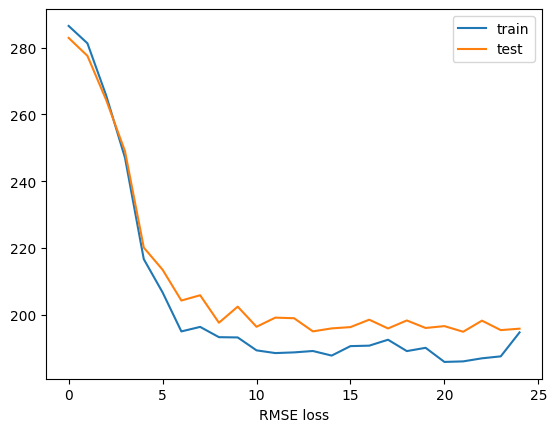

In [28]:
train_loss, test_loss = [], []
epoch = 25
for epoch in range(epoch):
    train()
    train_loss.append(test(train_loader))
    test_loss.append(test(test_loader))
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}')

plt.plot(range(epoch+1), train_loss, label="train")
plt.plot(range(epoch+1), test_loss, label="test")
plt.xlabel("Number of epochs")
plt.xlabel("RMSE loss")
plt.legend()
plt.show()